In [1]:
import IPython
import IPython.display
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import sklearn as sk
from sklearn.model_selection import train_test_split
#from keras.layers import CuDNNGRU

# Comienzo experimento

In [2]:
df = pd.read_hdf('gaia_data2vec_full_4features.hdf')

In [3]:
df.shape

(4527495, 4)

In [4]:
sample_size = 27    #22 entradas, 5 salidas
salidas = 5

## Data split

#### to Numpy > reshape flat

In [5]:
df_array = df.to_numpy()
array_flat = np.reshape(df_array,((int(len(df)/sample_size), sample_size, df.shape[1])))
#df_array.shape

#### split train, test, val

In [6]:
#80% train, 10% val, 10% test
column_indices = {name: i for i, name in enumerate(df.columns)}

X_train_val, test_df = train_test_split(array_flat, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(X_train_val, test_size=0.11, random_state=42)

In [7]:
print('train: ', train_df.shape)
print('val: ', val_df.shape)
print('test: ', test_df.shape)

train:  (134315, 27, 4)
val:  (16601, 27, 4)
test:  (16769, 27, 4)


In [8]:
train_df.shape[2]

4

#### reshape original > to df

In [9]:
train_df = np.reshape(train_df,(int(len(train_df)*sample_size), train_df.shape[2]))
val_df = np.reshape(val_df,(int(len(val_df)*sample_size), val_df.shape[2]))
test_df = np.reshape(test_df,(int(len(test_df)*sample_size), test_df.shape[2]))

train_df = pd.DataFrame(train_df, columns = ['time','mag', 'difftime', 'diffmag'])
val_df = pd.DataFrame(val_df, columns = ['time','mag', 'difftime', 'diffmag'])
test_df = pd.DataFrame(test_df, columns = ['time','mag', 'difftime', 'diffmag'])

num_features = df.shape[1]
#print(train_df)

In [10]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3626505, 4)
(448227, 4)
(452763, 4)


### Normalización


In [11]:
#Normalización
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [13]:

w1 = WindowGenerator(input_width=22, label_width=salidas, shift=salidas,
                     label_columns=['mag'])
w1

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label indices: [22 23 24 25 26]
Label column name(s): ['mag']

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[w1.total_window_size:2*w1.total_window_size]),
                           np.array(train_df[2*w1.total_window_size:3*w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 27, 4)
Inputs shape: (3, 22, 4)
Labels shape: (3, 5, 1)


In [16]:
w1.example = example_inputs, example_labels

In [17]:
def plot(self, model=None, plot_col= 'mag', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Tiempo')

WindowGenerator.plot = plot

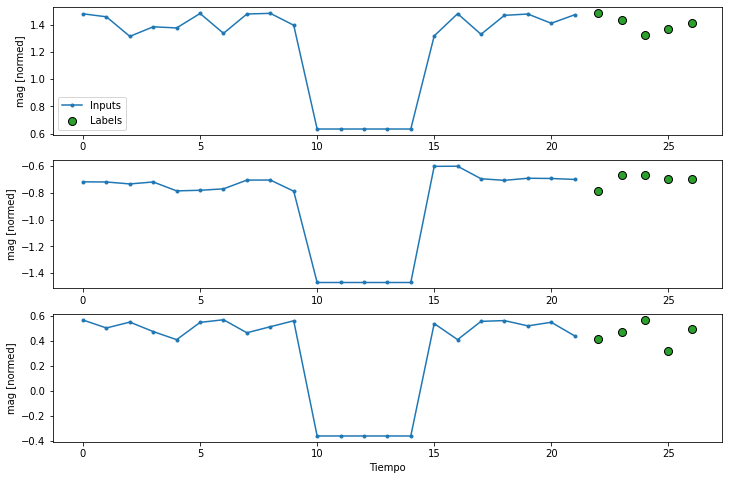

In [18]:
w1.plot()

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      #sequence_stride=1
      sequence_stride=sample_size,
      shuffle=True,
      #shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
#Cada elemento es un par (inputs, label).
w1.train.element_spec

(TensorSpec(shape=(None, 22, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None))

In [22]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 22, 4)
Labels shape (batch, time, features): (32, 5, 1)


In [23]:
single_step_window = WindowGenerator(
    input_width=22, label_width=1, shift=1,
    label_columns=['mag'])
single_step_window

Total window size: 23
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label indices: [22]
Label column name(s): ['mag']

In [24]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 22, 4)
Labels shape (batch, time, features): (32, 1, 1)


In [25]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2

In [26]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

# Training y save

In [27]:
MAX_EPOCHS = 500
def compile_and_fit(model, window, patience=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',
                                                    patience=patience,
                                                    mode='min')
  
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), R_squared])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, model_checkpoint_callback],
                      verbose = 1)
    return history

In [28]:
OUT_STEPS = 5
wide_step_window = WindowGenerator(
    input_width=22, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['mag'])
wide_step_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label indices: [22 23 24 25 26]
Label column name(s): ['mag']

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label indices: [22 23 24 25 26]
Label column name(s): None

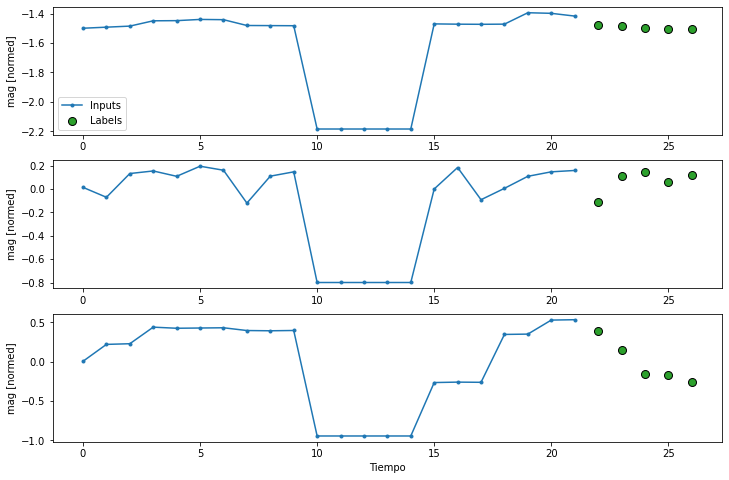

In [29]:
multi_window = WindowGenerator(input_width=22,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

4198/4198 [==============================] - 10s 2ms/step - loss: 5.7756 - mean_absolute_error: 1.4344 - R_squared: -11.4065


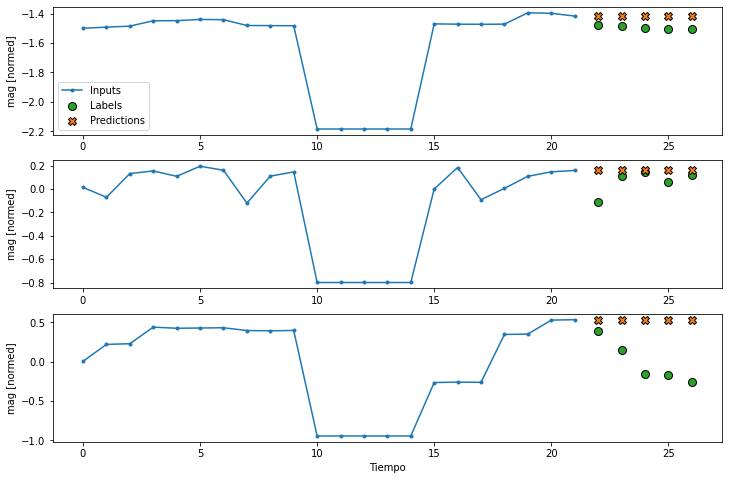

In [30]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(),
                              R_squared])

val_performance = {}
performance = {}
train_performance = {}

val_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=1)
performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=1)
train_performance['Last'] = last_baseline.evaluate(multi_window.train, verbose=1)
multi_window.plot(last_baseline)


Epoch 1/3
4198/4198 [==============================] - 47s 10ms/step - loss: 0.0524 - mean_absolute_error: 0.1282 - R_squared: 0.8884 - val_loss: 0.0308 - val_mean_absolute_error: 0.0892 - val_R_squared: 0.9343
Epoch 2/3
4198/4198 [==============================] - 43s 10ms/step - loss: 0.0301 - mean_absolute_error: 0.0905 - R_squared: 0.9359 - val_loss: 0.0277 - val_mean_absolute_error: 0.0801 - val_R_squared: 0.9406
Epoch 3/3
4198/4198 [==============================] - 20s 5ms/step - loss: 0.0262 - mean_absolute_error: 0.0771 - R_squared: 0.9441


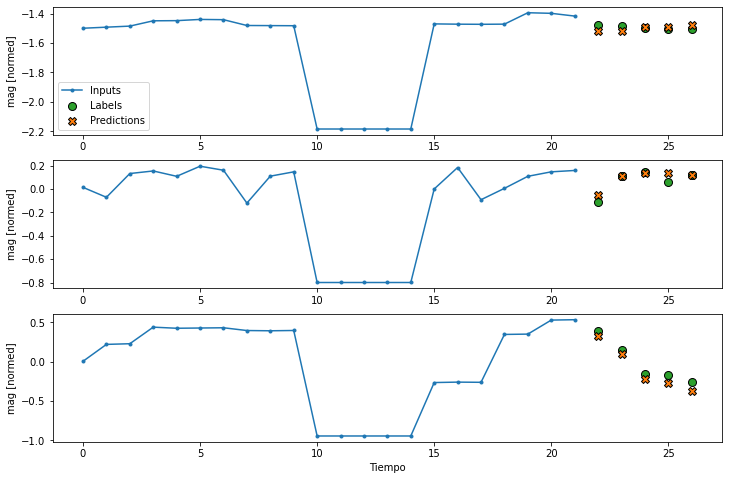

In [31]:
checkpoint_filepath = "D:\Clases\Tesis\Datasets\Gaia\LSTM\\"

lstm_model = tf.keras.Sequential([
    tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.compat.v1.keras.layers.CuDNNLSTM(16, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(lstm_model, multi_window)
val_performance = {}
performance = {}
train_performance = {}

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val, verbose=1)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=1)
train_performance['LSTM'] = lstm_model.evaluate(multi_window.train, verbose=1)
multi_window.plot(lstm_model)

In [32]:
#multi_lstm_model.save("multi_lstm_model_data2vec_gaia.h5") 

4198/4198 [==============================] - 24s 6ms/step - loss: 0.9273 - mean_absolute_error: 0.6845 - R_squared: -0.9529


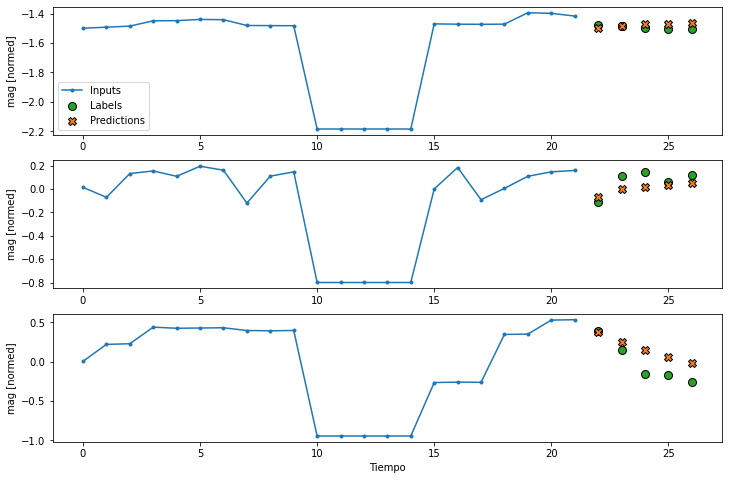

In [33]:
checkpoint_filepath = "D:\Clases\Tesis\Datasets\Gaia\GRU\\"
gru_model = tf.keras.Sequential([
    tf.compat.v1.keras.layers.CuDNNGRU(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.compat.v1.keras.layers.CuDNNGRU(64, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.compat.v1.keras.layers.CuDNNGRU(16, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


history = compile_and_fit(gru_model, wide_step_window)
val_performance = {}
performance = {}
train_performance = {}

val_performance['GRU'] = gru_model.evaluate(multi_window.val, verbose=1)
performance['GRU'] = gru_model.evaluate(multi_window.test, verbose=1)
train_performance['GRU'] = gru_model.evaluate(multi_window.train, verbose=1)
multi_window.plot(gru_model)

In [34]:
#multi_gru_model.save("multi_gru_model_data2vec_gaia.h5") 